## A study of the NATICUSdroid dataset

*By Augustin GRUNEWALD & Nils FALCOZ*

We invite you to see the introduction comments about the dataset in the ReadME.


## Loading modules and the dataset

In [83]:
# Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import xgboost

In [2]:
# Dataset
original_df = pd.read_csv("data/data.csv", delimiter=",")

## Exploring the dataset
### Basics information

In [3]:
# Basic information (shape, ...)
print(f"Dataset shape : {original_df.shape}")
print(f"Number features : {original_df.shape[1]}")
print(f"Number sample : {original_df.shape[0]}")
original_df.info()

Dataset shape : (29332, 87)
Number features : 87
Number sample : 29332
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29332 entries, 0 to 29331
Data columns (total 87 columns):
 #   Column                                                                         Non-Null Count  Dtype
---  ------                                                                         --------------  -----
 0   android.permission.GET_ACCOUNTS                                                29332 non-null  int64
 1   com.sonyericsson.home.permission.BROADCAST_BADGE                               29332 non-null  int64
 2   android.permission.READ_PROFILE                                                29332 non-null  int64
 3   android.permission.MANAGE_ACCOUNTS                                             29332 non-null  int64
 4   android.permission.WRITE_SYNC_SETTINGS                                         29332 non-null  int64
 5   android.permission.READ_EXTERNAL_STORAGE                                 

In [4]:
# Showing a bit of the dataset
original_df.head()

,android.permission.GET_ACCOUNTS,com.sonyericsson.home.permission.BROADCAST_BADGE,android.permission.READ_PROFILE,android.permission.MANAGE_ACCOUNTS,android.permission.WRITE_SYNC_SETTINGS,android.permission.READ_EXTERNAL_STORAGE,android.permission.RECEIVE_SMS,com.android.launcher.permission.READ_SETTINGS,android.permission.WRITE_SETTINGS,com.google.android.providers.gsf.permission.READ_GSERVICES,...,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.sec.android.iap.permission.BILLING,com.htc.launcher.permission.UPDATE_SHORTCUT,com.sec.android.provider.badge.permission.WRITE,android.permission.ACCESS_NETWORK_STATE,com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE,com.huawei.android.launcher.permission.READ_SETTINGS,android.permission.READ_SMS,android.permission.PROCESS_INCOMING_CALLS,Result
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [5]:
# Checking for missing values - should find non missing values
print(f"All values are non missing : {np.all(original_df.isna() == False)}")

# Checking the nature of data - all values should be int64
print(f"All values are int64 : {np.all(original_df.dtypes == np.int64)}")

# Checking that all values are 0 or 1 - adding two df of booleans with method .add
print(f"All values are 0 or 1 : {np.all((original_df == 0).add(original_df == 1))}")

All values are non missing : True
All values are int64 : True
All values are 0 or 1 : True


In [6]:
# Checking the number of benign (result = 0) and malware (result = 1) apps
benign_df = original_df[original_df["Result"] == 0]
malware_df = original_df[original_df["Result"] == 1]
print(f"Benign data shape : {benign_df.shape}")
print(f"Malware data shape : {malware_df.shape}")

Benign data shape : (14632, 87)
Malware data shape : (14700, 87)


*Short summary* : All values are 0 or 1, there's no missing values to be handle, we have about the same amount of data for each case : benign and malware, which will be very useful for the trainings in order to have balanced models.

*Note* : The name of the dataset "NATICUS" comes from the contraction of "Native" & "Custom" permissions requests. The authors in the article working on this dataset make a distinction between the dataset with native permissions and the one with all the permissions. After some looking at the permissions labels, is considered as native, a permission containing the terms "android.permission" or "com.android".

In [7]:
# Looking only at the native permission requests - starting with keyword android.permission or com.android
native_columns = np.array([[i, label] for i, label in enumerate(original_df.columns) if ("android.permission" in label) or ("com.android" in label)])
non_native_columns = np.array([[i, label] for i, label in enumerate(original_df.columns) if ("android.permission" not in label) and ("com.android" not in label) and label != "Result"]) # Keeping the result column in the native permission_df

native_permissions_df = (original_df.copy()).drop(list(non_native_columns[:,1]), axis=1)

print(f"Native permission requests dataset shape : {native_permissions_df.shape}")
print(f"Naticus (native + custom) permission requests dataset shape : {original_df.shape}")

Native permission requests dataset shape : (29332, 65)
Naticus (native + custom) permission requests dataset shape : (29332, 87)


In [8]:
# For the next part of the notebook, we'll work with these two datasets
naticus_df = original_df.copy()                  # Native + Custom permissions
native_df = native_permissions_df.copy()         # Native permissions

### Feature selection
Let's make a bit of feature selection before training any models. 

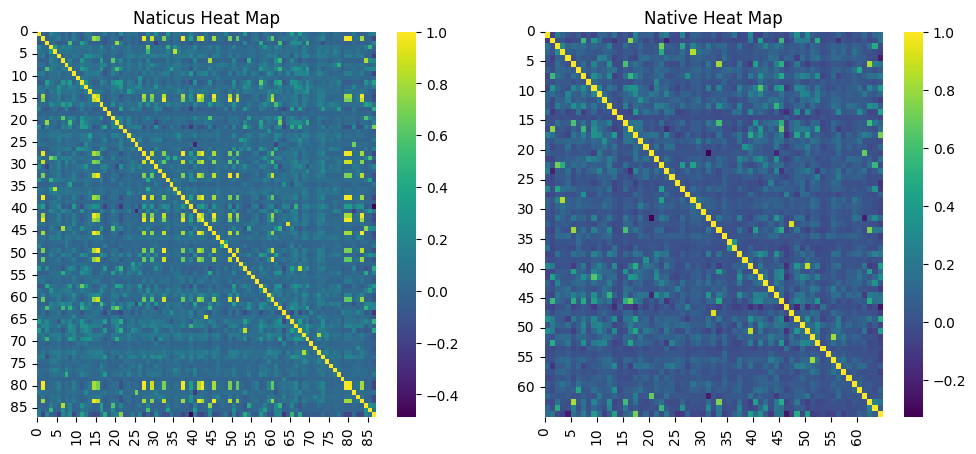

In [9]:
# Initial heat map
naticus_corr = naticus_df.corr()
native_corr = native_df.corr()

# Removing the labels of each permissions by its index
naticus_corr.index = range(len(naticus_corr))
naticus_corr.columns = range(len(naticus_corr.columns))
native_corr.index = range(len(native_corr))
native_corr.columns = range(len(native_corr.columns))

# Plotting the heat maps using seaborn
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes.flatten()

# Ticks only 5 by 5
step = 5

sns.heatmap(naticus_corr, ax=axes[0], cmap='viridis', vmin=naticus_corr.min().min(), vmax=1)
axes[0].set_xticks(np.arange(0, len(naticus_corr), step))
axes[0].set_yticks(np.arange(0, len(naticus_corr), step))
axes[0].set_xticklabels(np.arange(0, len(naticus_corr), step))
axes[0].set_yticklabels(np.arange(0, len(naticus_corr), step), rotation=0)
axes[0].set_title("Naticus Heat Map")

sns.heatmap(native_corr, ax=axes[1], cmap='viridis', vmin=native_corr.min().min(), vmax=1)
axes[1].set_xticks(np.arange(0, len(native_corr), step))
axes[1].set_yticks(np.arange(0, len(native_corr), step))
axes[1].set_xticklabels(np.arange(0, len(native_corr), step))
axes[1].set_yticklabels(np.arange(0, len(native_corr), step), rotation=0)
axes[1].set_title("Native Heat Map");


For now, looking at the correlations, it seems that we have a few moderate correlation, especially for the Naticus dataset. We can work on it to try to clear it.

Let's first look at the occurrences of all these permissions, and see if some really non important permissions could be removed. 

Number of columns to drop - Naticus : 26
Number of columns to drop - Native : 20


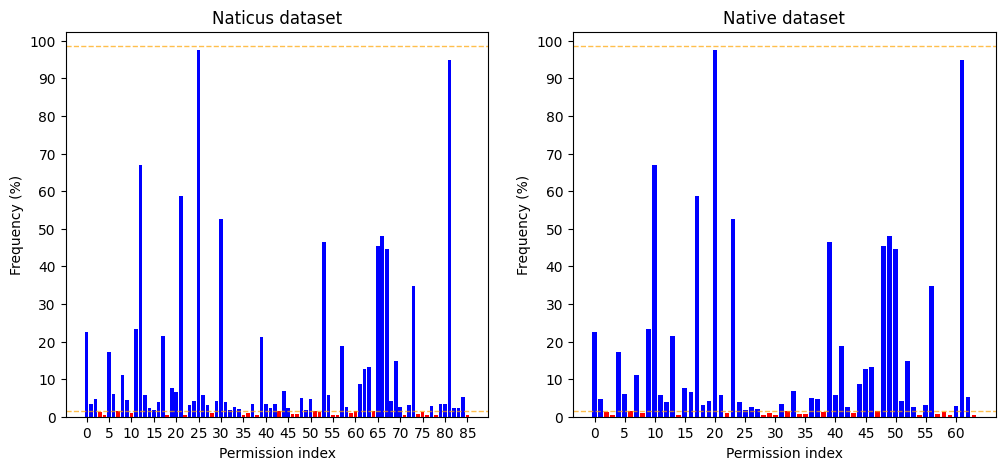

In [10]:
# Frequency counting - Looking at the appearance of each permissions by counting them (binary data)
naticus_frequency = naticus_df.sum()/naticus_df.shape[0]
native_frequency = native_df.sum()/native_df.shape[0]

# Threshold value - under "threshold" of frequency / above 100 - "threshold" of frequency, we remove the feature 
# Could also be done with sklearn VarianceThreshold - works not exactly the same but a bit
threshold = 0.015
naticus_cols_to_drop = naticus_frequency[(naticus_frequency < threshold) | (naticus_frequency > 1 - threshold)].index
native_cols_to_drop = native_frequency[(native_frequency < threshold) | (native_frequency > 1 - threshold)].index
print(f"Number of columns to drop - Naticus : {len(naticus_cols_to_drop)}")
print(f"Number of columns to drop - Native : {len(native_cols_to_drop)}")

# Plotting
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes.flatten()

axes[0].bar(range(naticus_df.shape[1] - 1), 100 * naticus_frequency[:-1], color=['red' if col in naticus_cols_to_drop else 'blue' for col in naticus_frequency.index[:-1]])
axes[0].axhline(y=100*threshold, color='orange', alpha=0.7, linestyle='--', linewidth=1)
axes[0].axhline(y=100*(1-threshold), color='orange', alpha=0.7, linestyle='--', linewidth=1)
axes[0].set_xticks(np.arange(0, len(naticus_frequency), 5))
axes[0].set_yticks(np.arange(0, 101, 10))
axes[0].set_ylabel("Frequency (%)")
axes[0].set_xlabel("Permission index")
axes[0].set_title("Naticus dataset")

axes[1].bar(range(native_df.shape[1] - 1), 100 * native_frequency[:-1], color=['red' if col in native_cols_to_drop else 'blue' for col in native_frequency.index[:-1]])
axes[1].axhline(y=100*threshold, color='orange', alpha=0.7, linestyle='--', linewidth=1)
axes[1].axhline(y=100*(1-threshold), color='orange', alpha=0.7, linestyle='--', linewidth=1)
axes[1].set_xticks(np.arange(0, len(native_frequency), 5))
axes[1].set_yticks(np.arange(0, 101, 10))
axes[1].set_ylabel("Frequency (%)")
axes[1].set_xlabel("Permission index")
axes[1].set_title("Native dataset");

In [11]:
# Updating the dataframes to work with
naticus_df = naticus_df.drop(naticus_cols_to_drop, axis=1)
native_df = native_df.drop(native_cols_to_drop, axis=1)

We have, this way, removed a good amount os features that have to real impact (less then 1.5% of frequency occurrences).

We now finally take a look at the highly correlated features and only keep one for the features correlated at more than 95%.

In [12]:
# Computing correlations matrix
naticus_corr = naticus_df.corr()
native_corr = native_df.corr()

# Keeping upper part of the correlation matrix  
upper_naticus = naticus_corr.where(np.triu(np.ones(naticus_corr.shape), k=1).astype(bool))
upper_native = native_corr.where(np.triu(np.ones(native_corr.shape), k=1).astype(bool))

# Threshold
threshold = 0.97

# Columns to drop
naticus_cols_to_drop = [column for column in upper_naticus.columns if any(upper_naticus[column] > threshold)]
native_cols_to_drop = [column for column in upper_native.columns if any(upper_native[column] > threshold)]

print(f"Highly correlated features - Naticus : {naticus_cols_to_drop}")
print(f"Highly correlated features - Native : {native_cols_to_drop}")

Highly correlated features - Naticus : ['com.majeur.launcher.permission.UPDATE_BADGE', 'android.permission.READ_APP_BADGE', 'com.anddoes.launcher.permission.UPDATE_COUNT', 'com.sonymobile.home.permission.PROVIDER_INSERT_BADGE', 'com.sec.android.provider.badge.permission.READ', 'com.huawei.android.launcher.permission.WRITE_SETTINGS', 'com.oppo.launcher.permission.WRITE_SETTINGS', 'com.htc.launcher.permission.UPDATE_SHORTCUT', 'com.sec.android.provider.badge.permission.WRITE', 'com.huawei.android.launcher.permission.READ_SETTINGS']
Highly correlated features - Native : []


In [13]:
# Updating the dataframes to work with
naticus_df = naticus_df.drop(naticus_cols_to_drop, axis=1)
native_df = native_df.drop(native_cols_to_drop, axis=1)

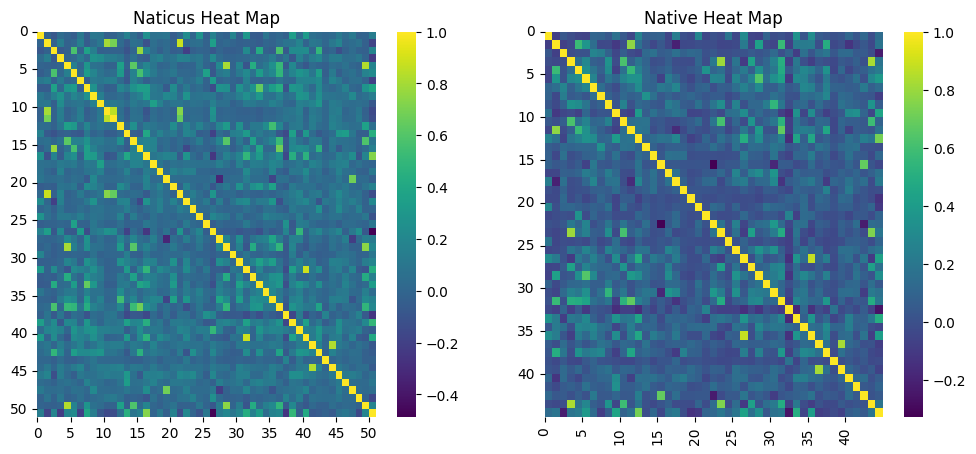

In [14]:
# Final heat map
naticus_corr = naticus_df.corr()
native_corr = native_df.corr()

# Removing the labels of each permissions by its index
naticus_corr.index = range(len(naticus_corr))
naticus_corr.columns = range(len(naticus_corr.columns))
native_corr.index = range(len(native_corr))
native_corr.columns = range(len(native_corr.columns))

# Plotting the heat maps using seaborn
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes.flatten()

# Ticks only 5 by 5
step = 5

sns.heatmap(naticus_corr, ax=axes[0], cmap='viridis', vmin=naticus_corr.min().min(), vmax=1)
axes[0].set_xticks(np.arange(0, len(naticus_corr), step))
axes[0].set_yticks(np.arange(0, len(naticus_corr), step))
axes[0].set_xticklabels(np.arange(0, len(naticus_corr), step))
axes[0].set_yticklabels(np.arange(0, len(naticus_corr), step), rotation=0)
axes[0].set_title("Naticus Heat Map")

sns.heatmap(native_corr, ax=axes[1], cmap='viridis', vmin=native_corr.min().min(), vmax=1)
axes[1].set_xticks(np.arange(0, len(native_corr), step))
axes[1].set_yticks(np.arange(0, len(native_corr), step))
axes[1].set_xticklabels(np.arange(0, len(native_corr), step))
axes[1].set_yticklabels(np.arange(0, len(native_corr), step), rotation=0)
axes[1].set_title("Native Heat Map");


In [15]:
# Final shapes
print(f"Naticus dataset shape : {naticus_df.shape}")
print(f"Native dataset shape : {native_df.shape}")

Naticus dataset shape : (29332, 51)
Native dataset shape : (29332, 45)


*Conclusion* : finally our dataset has been a bit cleaned, we've removed insignificant features and also highly correlated ones. We've keep 51 permissions (native and customed), with 45 natives. 

## Building models on the dataset

In this part, we proposed to build a detection malware framework based on this hugh dataset. We're going to use different classification models and compare them using specific metrics.

| Single Learners | Ensemble Learners | Metrics |
|---------------------------|------|------|
| Logistic Regression |Random Forest|Accuracy|
| K-Nearest Neighbors | XGBoost| F1Score|
| Support Vector Machines | AdaBoost| ROC Curve|
| - | Bagging| - |

For all models we're going to need training and validation data so let's split these before starting any model

In [16]:
from sklearn.model_selection import train_test_split

# Splitting training/testing
X_naticus_train, X_naticus_test, y_naticus_train, y_naticus_test = train_test_split(naticus_df.iloc[:,:-1], naticus_df.iloc[:,-1], test_size=0.3, random_state=42)
X_native_train, X_native_test, y_native_train, y_native_test = train_test_split(native_df.iloc[:,:-1], native_df.iloc[:,-1], test_size=0.3, random_state=42)

# Checking we've about half malware/benign in training and testing dataset
print(f"Naticus Training dataset : malware = {y_naticus_train.sum()} | benign = {len(y_naticus_train) - y_naticus_train.sum()} -> {100 * y_naticus_train.sum() / len(y_naticus_train):.2f}% & {100 - 100 * y_naticus_train.sum() / len(y_naticus_train):.2f}%")
print(f"Naticus Testing dataset : malware = {y_naticus_test.sum()} | benign = {len(y_naticus_test) - y_naticus_test.sum()} -> {100 * y_naticus_test.sum() / len(y_naticus_test):.2f}% & {100 - 100 * y_naticus_test.sum() / len(y_naticus_test):.2f}%")
print("\n")
print(f"Native Training dataset : malware = {y_native_train.sum()} | benign = {len(y_native_train) - y_native_train.sum()} -> {100 * y_native_train.sum() / len(y_native_train):.2f}% & {100 - 100 * y_native_train.sum() / len(y_native_train):.2f}%")
print(f"Native Testing dataset : malware = {y_native_test.sum()} | benign = {len(y_native_test) - y_native_test.sum()} -> {100 * y_native_test.sum() / len(y_native_test):.2f}% & {100 - 100 * y_native_test.sum() / len(y_native_test):.2f}%")

Naticus Training dataset : malware = 10319 | benign = 10213 -> 50.26% & 49.74%
Naticus Testing dataset : malware = 4381 | benign = 4419 -> 49.78% & 50.22%


Native Training dataset : malware = 10319 | benign = 10213 -> 50.26% & 49.74%
Native Testing dataset : malware = 4381 | benign = 4419 -> 49.78% & 50.22%


*Note* : we have the same percentages, as we're using the same random key, that's normal.

### Single Learners - Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Metrics used for the scoring
scoring_metrics = {
    'Accuracy': 'accuracy', 
    'F1_Score': 'f1',
    'ROC_AUC': 'roc_auc'
}

# Hyperparameters grid
param_grid = {
    'C':[0.01,0.1,1,10],
    'penalty':['l1','l2'],
    'max_iter':[100,500]
}

# KFold & search for best hyperparameters
grid_lr_naticus = GridSearchCV(
    estimator=LogisticRegression(solver="liblinear"),       # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

grid_lr_native = GridSearchCV(
    estimator=LogisticRegression(solver="liblinear"),       # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

# Training while searching for best hyperparameters
grid_lr_naticus.fit(X_naticus_train, y_naticus_train)
grid_lr_native.fit(X_native_train, y_native_train);

In [47]:
# Saving the results
lr_naticus_results = pd.DataFrame(grid_lr_naticus.cv_results_)
lr_native_results = pd.DataFrame(grid_lr_native.cv_results_)

# Best models 
lr_naticus = grid_lr_naticus.best_estimator_
lr_naticus_ind = grid_lr_naticus.best_index_
lr_native = grid_lr_native.best_estimator_
lr_native_ind = grid_lr_native.best_index_

# Showing best hyperparameters/score
print(40 * "* ")
print("Best Model NATICUS (according to ROC AUC)")
print(f"* Hyperparameters : {grid_lr_naticus.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {lr_naticus_results.loc[lr_naticus_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {lr_naticus_results.loc[lr_naticus_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {lr_naticus_results.loc[lr_naticus_ind, 'mean_test_Accuracy']:.4f}")

print("\n" + 40 * "* " + "\n")

print("Best Model NATIVE (according to ROC AUC)")
print(f"* Hyperparameters : {grid_lr_native.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {lr_native_results.loc[lr_native_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {lr_native_results.loc[lr_native_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {lr_native_results.loc[lr_native_ind, 'mean_test_Accuracy']:.4f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS (according to ROC AUC)
* Hyperparameters : {'C': 10, 'max_iter': 100, 'penalty': 'l1'}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9871
* F1 Score : 0.9533
* Accuracy : 0.9527

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE (according to ROC AUC)
* Hyperparameters : {'C': 10, 'max_iter': 500, 'penalty': 'l1'}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9798
* F1 Score : 0.9442
* Accuracy : 0.9433
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [19]:
# Validation of the best models - Prediction of the class and associated probability
y_naticus_pred_lr = lr_naticus.predict(X_naticus_test)
y_naticus_proba_lr = lr_naticus.predict_proba(X_naticus_test)[:, 1] # Looking at the proba of 1 = proba malware

y_native_pred_lr = lr_native.predict(X_native_test)
y_native_proba_lr = lr_native.predict_proba(X_native_test)[:, 1]

# Printing scores
print(40 * "* ")
print("Best Model NATICUS on validation set")
print(f"* ROC AUC : {roc_auc_score(y_naticus_test, y_naticus_proba_lr):.5f}")
print(f"* F1 Score : {f1_score(y_naticus_test, y_naticus_pred_lr):.5f}")
print(f"* Accuracy : {accuracy_score(y_naticus_test, y_naticus_pred_lr):.5f}")
print("\n" + 40 * "* " + "\n")
print("Best Model NATIVE on validation set")
print(f"* ROC AUC : {roc_auc_score(y_native_test, y_native_proba_lr):.5f}")
print(f"* F1 Score : {f1_score(y_native_test, y_native_pred_lr):.5f}")
print(f"* Accuracy : {accuracy_score(y_native_test, y_native_pred_lr):.5f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS on validation set
* ROC AUC : 0.98853
* F1 Score : 0.95745
* Accuracy : 0.95739

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE on validation set
* ROC AUC : 0.98135
* F1 Score : 0.94124
* Accuracy : 0.94080
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


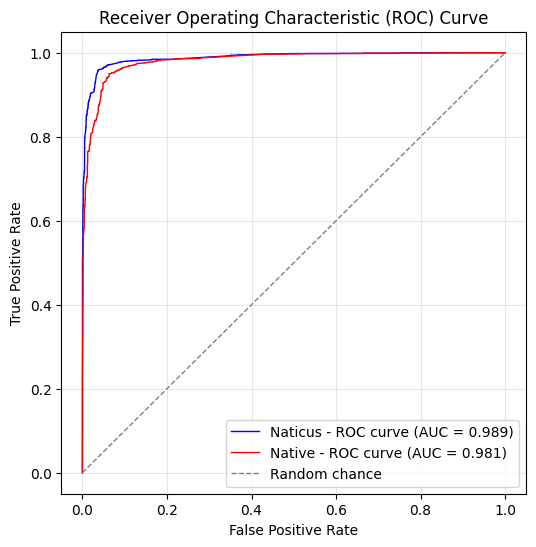

In [20]:
from sklearn.metrics import roc_curve, auc

# ROC_AUC curves
fpr_naticus_lr, tpr_naticus_lr, _ = roc_curve(y_naticus_test, y_naticus_proba_lr)
roc_auc_naticus_lr = auc(fpr_naticus_lr, tpr_naticus_lr)
fpr_native_lr, tpr_native_lr, _ = roc_curve(y_native_test, y_native_proba_lr)
roc_auc_native_lr = auc(fpr_native_lr, tpr_native_lr)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_naticus_lr, tpr_naticus_lr, color='blue', lw=1, label=f'Naticus - ROC curve (AUC = {roc_auc_naticus_lr:.3f})')
axes.plot(fpr_native_lr, tpr_native_lr, color='red', lw=1, label=f'Native - ROC curve (AUC = {roc_auc_native_lr:.3f})')
axes.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')

axes.set_title("Receiver Operating Characteristic (ROC) Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid(alpha=0.3)
axes.legend();


Both models show excellent performance on the validation set.

- **Naticus model** achieved a **ROC AUC of 0.9885**, with **F1 = 0.957** and **Accuracy = 0.957**, indicating very strong discrimination between malware and benign apps.

- **Native model** also performed highly, with **ROC AUC = 0.981**, **F1 = 0.941**, and **Accuracy = 0.941**, demonstrating good generalization.

Overall, both models effectively capture key permission patterns that distinguish malicious from legitimate applications.

### Single Learners - K-Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameters grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# KFold & search for best hyperparameters
grid_knn_naticus = GridSearchCV(
    estimator=KNeighborsClassifier(),                       # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

grid_knn_native = GridSearchCV(
    estimator=KNeighborsClassifier(),                       # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

# Training while searching for best hyperparameters
grid_knn_naticus.fit(X_naticus_train, y_naticus_train)
grid_knn_native.fit(X_native_train, y_native_train);

In [48]:
# Saving the results
knn_naticus_results = pd.DataFrame(grid_knn_naticus.cv_results_)
knn_native_results = pd.DataFrame(grid_knn_native.cv_results_)

# Best models 
knn_naticus = grid_knn_naticus.best_estimator_
knn_naticus_ind = grid_knn_naticus.best_index_
knn_native = grid_knn_native.best_estimator_
knn_native_ind = grid_knn_native.best_index_

# Showing best hyperparameters/score
print(40 * "* ")
print("Best Model NATICUS (according to ROC AUC)")
print(f"* Hyperparameters : {grid_knn_naticus.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {knn_naticus_results.loc[knn_naticus_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {knn_naticus_results.loc[knn_naticus_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {knn_naticus_results.loc[knn_naticus_ind, 'mean_test_Accuracy']:.4f}")

print("\n" + 40 * "* " + "\n")

print("Best Model NATIVE (according to ROC AUC)")
print(f"* Hyperparameters : {grid_knn_native.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {knn_native_results.loc[knn_native_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {knn_native_results.loc[knn_native_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {knn_native_results.loc[knn_native_ind, 'mean_test_Accuracy']:.4f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS (according to ROC AUC)
* Hyperparameters : {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9874
* F1 Score : 0.9588
* Accuracy : 0.9584

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE (according to ROC AUC)
* Hyperparameters : {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9849
* F1 Score : 0.9516
* Accuracy : 0.9512
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [24]:
# Validation of the best models - Prediction of the class and associated probability
y_naticus_pred_knn = knn_naticus.predict(X_naticus_test)
y_naticus_proba_knn = knn_naticus.predict_proba(X_naticus_test)[:, 1] # Looking at the proba of 1 = proba malware

y_native_pred_knn = knn_native.predict(X_native_test)
y_native_proba_knn = knn_native.predict_proba(X_native_test)[:, 1]

# Printing scores
print(40 * "* ")
print("Best Model NATICUS on validation set")
print(f"* ROC AUC : {roc_auc_score(y_naticus_test, y_naticus_proba_knn):.5f}")
print(f"* F1 Score : {f1_score(y_naticus_test, y_naticus_pred_knn):.5f}")
print(f"* Accuracy : {accuracy_score(y_naticus_test, y_naticus_pred_knn):.5f}")
print("\n" + 40 * "* " + "\n")
print("Best Model NATIVE on validation set")
print(f"* ROC AUC : {roc_auc_score(y_native_test, y_native_proba_knn):.5f}")
print(f"* F1 Score : {f1_score(y_native_test, y_native_pred_knn):.5f}")
print(f"* Accuracy : {accuracy_score(y_native_test, y_native_pred_knn):.5f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS on validation set
* ROC AUC : 0.98977
* F1 Score : 0.95964
* Accuracy : 0.95977

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE on validation set
* ROC AUC : 0.98327
* F1 Score : 0.95221
* Accuracy : 0.95216
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


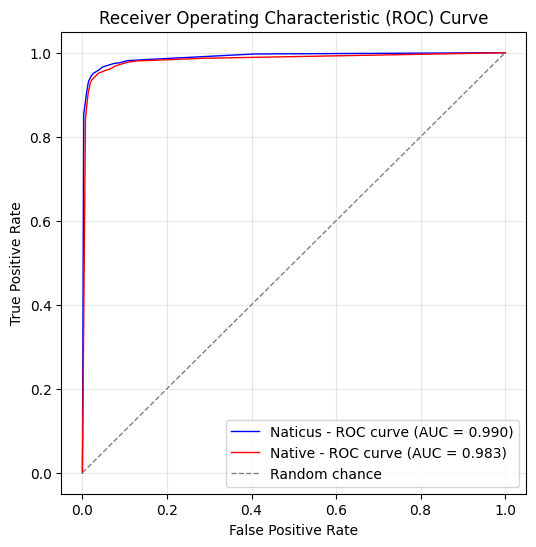

In [25]:
# ROC_AUC curves
fpr_naticus_knn, tpr_naticus_knn, _ = roc_curve(y_naticus_test, y_naticus_proba_knn)
roc_auc_naticus_knn = auc(fpr_naticus_knn, tpr_naticus_knn)
fpr_native_knn, tpr_native_knn, _ = roc_curve(y_native_test, y_native_proba_knn)
roc_auc_native_knn = auc(fpr_native_knn, tpr_native_knn)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_naticus_knn, tpr_naticus_knn, color='blue', lw=1, label=f'Naticus - ROC curve (AUC = {roc_auc_naticus_knn:.3f})')
axes.plot(fpr_native_knn, tpr_native_knn, color='red', lw=1, label=f'Native - ROC curve (AUC = {roc_auc_native_knn:.3f})')
axes.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')

axes.set_title("Receiver Operating Characteristic (ROC) Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid(alpha=0.3)
axes.legend();

### Single Learners - Support Vector Machines

In [26]:
from sklearn.svm import SVC

# Hyperparameters grid
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
    {'kernel': ['rbf'],    'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
]

# KFold & search for best hyperparameters
grid_svm_naticus = GridSearchCV(
    estimator=SVC(random_state=42),                         # Base model  probability=True, 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

grid_svm_native = GridSearchCV(
    estimator=SVC(random_state=42),                         # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

# Training while searching for best hyperparameters
grid_svm_naticus.fit(X_naticus_train, y_naticus_train)
grid_svm_native.fit(X_native_train, y_native_train);

/Users/grunewaldaugustin/anaconda3/envs/naticus_project/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [98]:
# Saving the results
svm_naticus_results = pd.DataFrame(grid_svm_naticus.cv_results_)
svm_native_results = pd.DataFrame(grid_svm_native.cv_results_)

# Best models 
svm_naticus = grid_svm_naticus.best_estimator_
svm_naticus_ind = grid_svm_naticus.best_index_
svm_native = grid_svm_native.best_estimator_
svm_native_ind = grid_svm_native.best_index_

# Showing best hyperparameters/score
print(40 * "* ")
print("Best Model NATICUS (according to ROC AUC)")
print(f"* Hyperparameters : {grid_svm_naticus.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {svm_naticus_results.loc[svm_naticus_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {svm_naticus_results.loc[svm_naticus_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {svm_naticus_results.loc[svm_naticus_ind, 'mean_test_Accuracy']:.4f}")

print("\n" + 40 * "* " + "\n")

print("Best Model NATIVE (according to ROC AUC)")
print(f"* Hyperparameters : {grid_svm_native.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {svm_native_results.loc[svm_native_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {svm_native_results.loc[svm_native_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {svm_native_results.loc[svm_native_ind, 'mean_test_Accuracy']:.4f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS (according to ROC AUC)
* Hyperparameters : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9899
* F1 Score : 0.9662
* Accuracy : 0.9662

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE (according to ROC AUC)
* Hyperparameters : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9864
* F1 Score : 0.9573
* Accuracy : 0.9571
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [28]:
# Validation of the best models - Prediction of the class and associated probability
y_naticus_pred_svm = svm_naticus.predict(X_naticus_test)
y_naticus_proba_svm = svm_naticus.decision_function(X_naticus_test)# Looking at the proba of 1 = proba malware

y_native_pred_svm = svm_native.predict(X_native_test)
y_native_proba_svm = svm_native.decision_function(X_native_test)

# Printing scores
print(40 * "* ")
print("Best Model NATICUS on validation set")
print(f"* ROC AUC : {roc_auc_score(y_naticus_test, y_naticus_proba_svm):.5f}")
print(f"* F1 Score : {f1_score(y_naticus_test, y_naticus_pred_svm):.5f}")
print(f"* Accuracy : {accuracy_score(y_naticus_test, y_naticus_pred_svm):.5f}")
print("\n" + 40 * "* " + "\n")
print("Best Model NATIVE on validation set")
print(f"* ROC AUC : {roc_auc_score(y_native_test, y_native_proba_svm):.5f}")
print(f"* F1 Score : {f1_score(y_native_test, y_native_pred_svm):.5f}")
print(f"* Accuracy : {accuracy_score(y_native_test, y_native_pred_svm):.5f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS on validation set
* ROC AUC : 0.99157
* F1 Score : 0.96779
* Accuracy : 0.96830

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE on validation set
* ROC AUC : 0.98772
* F1 Score : 0.95649
* Accuracy : 0.95659
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


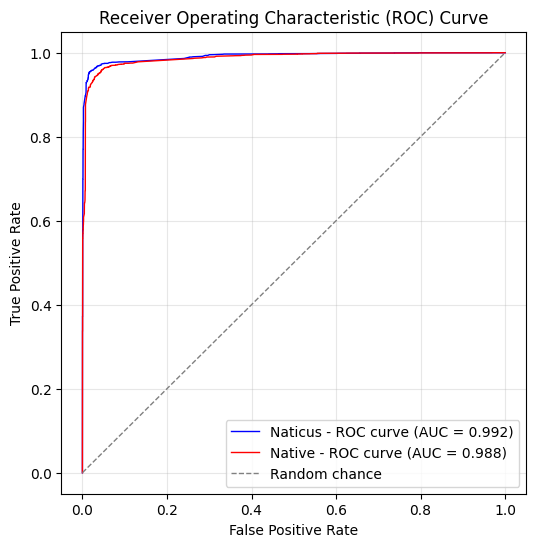

In [29]:
# ROC_AUC curves
fpr_naticus_svm, tpr_naticus_svm, _ = roc_curve(y_naticus_test, y_naticus_proba_svm)
roc_auc_naticus_svm = auc(fpr_naticus_svm, tpr_naticus_svm)
fpr_native_svm, tpr_native_svm, _ = roc_curve(y_native_test, y_native_proba_svm)
roc_auc_native_svm = auc(fpr_native_svm, tpr_native_svm)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_naticus_svm, tpr_naticus_svm, color='blue', lw=1, label=f'Naticus - ROC curve (AUC = {roc_auc_naticus_svm:.3f})')
axes.plot(fpr_native_svm, tpr_native_svm, color='red', lw=1, label=f'Native - ROC curve (AUC = {roc_auc_native_svm:.3f})')
axes.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')

axes.set_title("Receiver Operating Characteristic (ROC) Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid(alpha=0.3)
axes.legend();


### Ensemble Learners - Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Hyperparameters grid
param_grid = {
    'n_estimators': [200, 400, 800],
    'max_depth'  : [None, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

# KFold & search for best hyperparameters
grid_rf_naticus = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),      # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

grid_rf_native = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),      # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Used metrics
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

# Training while searching for best hyperparameters
grid_rf_naticus.fit(X_naticus_train, y_naticus_train)
grid_rf_native.fit(X_native_train, y_native_train);

In [97]:
# Saving the results
rf_naticus_results = pd.DataFrame(grid_rf_naticus.cv_results_)
rf_native_results = pd.DataFrame(grid_rf_native.cv_results_)

# Best models 
rf_naticus = grid_rf_naticus.best_estimator_
rf_naticus_ind = grid_rf_naticus.best_index_
rf_native = grid_rf_native.best_estimator_
rf_native_ind = grid_rf_native.best_index_

# Showing best hyperparameters/score
print(40 * "* ")
print("Best Model NATICUS (according to ROC AUC)")
print(f"* Hyperparameters : {grid_rf_naticus.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {rf_naticus_results.loc[rf_naticus_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {rf_naticus_results.loc[rf_naticus_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {rf_naticus_results.loc[rf_naticus_ind, 'mean_test_Accuracy']:.4f}")

print("\n" + 40 * "* " + "\n")

print("Best Model NATIVE (according to ROC AUC)")
print(f"* Hyperparameters : {grid_rf_native.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {rf_native_results.loc[rf_native_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {rf_native_results.loc[rf_native_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {rf_native_results.loc[rf_native_ind, 'mean_test_Accuracy']:.4f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS (according to ROC AUC)
* Hyperparameters : {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 800}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9934
* F1 Score : 0.9676
* Accuracy : 0.9675

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE (according to ROC AUC)
* Hyperparameters : {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 800}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9915
* F1 Score : 0.9615
* Accuracy : 0.9614
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [32]:
# Validation of the best models - Prediction of the class and associated probability
y_naticus_pred_rf = rf_naticus.predict(X_naticus_test)
y_naticus_proba_rf = rf_naticus.predict_proba(X_naticus_test)[:, 1] # Looking at the proba of 1 = proba malware

y_native_pred_rf = rf_native.predict(X_native_test)
y_native_proba_rf = rf_native.predict_proba(X_native_test)[:, 1]

# Printing scores
print(40 * "* ")
print("Best Model NATICUS on validation set")
print(f"* ROC AUC : {roc_auc_score(y_naticus_test, y_naticus_proba_rf):.5f}")
print(f"* F1 Score : {f1_score(y_naticus_test, y_naticus_pred_rf):.5f}")
print(f"* Accuracy : {accuracy_score(y_naticus_test, y_naticus_pred_rf):.5f}")
print("\n" + 40 * "* " + "\n")
print("Best Model NATIVE on validation set")
print(f"* ROC AUC : {roc_auc_score(y_native_test, y_native_proba_rf):.5f}")
print(f"* F1 Score : {f1_score(y_native_test, y_native_pred_rf):.5f}")
print(f"* Accuracy : {accuracy_score(y_native_test, y_native_pred_rf):.5f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS on validation set
* ROC AUC : 0.99448
* F1 Score : 0.96987
* Accuracy : 0.97011

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE on validation set
* ROC AUC : 0.99238
* F1 Score : 0.96190
* Accuracy : 0.96216
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


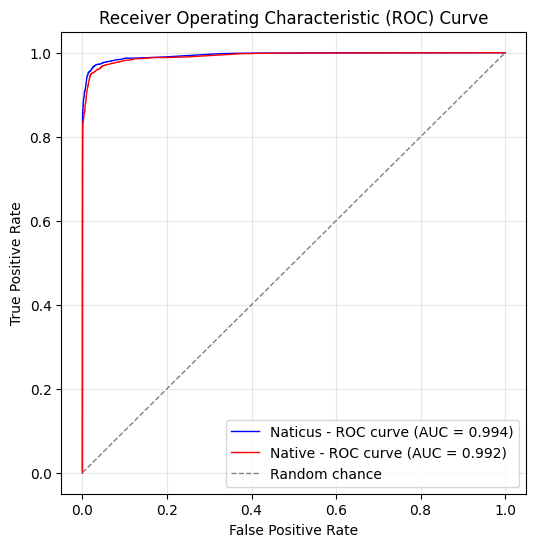

In [33]:
# ROC_AUC curves
fpr_naticus_rf, tpr_naticus_rf, _ = roc_curve(y_naticus_test, y_naticus_proba_rf)
roc_auc_naticus_rf = auc(fpr_naticus_rf, tpr_naticus_rf)
fpr_native_rf, tpr_native_rf, _ = roc_curve(y_native_test, y_native_proba_rf)
roc_auc_native_rf = auc(fpr_native_rf, tpr_native_rf)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_naticus_rf, tpr_naticus_rf, color='blue', lw=1, label=f'Naticus - ROC curve (AUC = {roc_auc_naticus_rf:.3f})')
axes.plot(fpr_native_rf, tpr_native_rf, color='red', lw=1, label=f'Native - ROC curve (AUC = {roc_auc_native_rf:.3f})')
axes.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')

axes.set_title("Receiver Operating Characteristic (ROC) Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid(alpha=0.3)
axes.legend();

### Ensemble Learners - XGBoost

In [34]:
from xgboost import XGBClassifier

# Hyperparameters grid
param_grid = {
    'n_estimators':[200, 500, 800],
    'max_depth':[5, 7, 10],
    'learning_rate':[0.01, 0.05, 0.1],
    'subsample':[0.6, 0.8, 1.0]
}

# KFold & search for best hyperparameters
grid_xgb_naticus = GridSearchCV(
    estimator=XGBClassifier(random_state=42),               # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Same metrics as before
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

grid_xgb_native = GridSearchCV(
    estimator=XGBClassifier(random_state=42),               # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Same metrics as before
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

# Training while searching for best hyperparameters
grid_xgb_naticus.fit(X_naticus_train, y_naticus_train)
grid_xgb_native.fit(X_native_train, y_native_train);

In [96]:
# Saving the results
xgb_naticus_results = pd.DataFrame(grid_xgb_naticus.cv_results_)
xgb_native_results = pd.DataFrame(grid_xgb_native.cv_results_)

# Best models 
xgb_naticus = grid_xgb_naticus.best_estimator_
xgb_naticus_ind = grid_xgb_naticus.best_index_
xgb_native = grid_xgb_native.best_estimator_
xgb_native_ind = grid_xgb_native.best_index_

# Showing best hyperparameters/score
print(40 * "* ")
print("Best Model NATICUS (according to ROC AUC)")
print(f"* Hyperparameters : {grid_xgb_naticus.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {xgb_naticus_results.loc[xgb_naticus_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {xgb_naticus_results.loc[xgb_naticus_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {xgb_naticus_results.loc[xgb_naticus_ind, 'mean_test_Accuracy']:.4f}")

print("\n" + 40 * "* " + "\n")

print("Best Model NATIVE (according to ROC AUC)")
print(f"* Hyperparameters : {grid_xgb_native.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {xgb_native_results.loc[xgb_native_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {xgb_native_results.loc[xgb_native_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {xgb_native_results.loc[xgb_native_ind, 'mean_test_Accuracy']:.4f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS (according to ROC AUC)
* Hyperparameters : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9933
* F1 Score : 0.9667
* Accuracy : 0.9667

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE (according to ROC AUC)
* Hyperparameters : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9915
* F1 Score : 0.9614
* Accuracy : 0.9615
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [36]:
# Validation of the best models - Prediction of the class and associated probability
y_naticus_pred_xgb = xgb_naticus.predict(X_naticus_test)
y_naticus_proba_xgb = xgb_naticus.predict_proba(X_naticus_test)[:, 1] # Looking at the proba of 1 = proba malware

y_native_pred_xgb = xgb_native.predict(X_native_test)
y_native_proba_xgb = xgb_native.predict_proba(X_native_test)[:, 1]

# Printing scores
print(40 * "* ")
print("Best Model NATICUS on validation set")
print(f"* ROC AUC : {roc_auc_score(y_naticus_test, y_naticus_proba_xgb):.5f}")
print(f"* F1 Score : {f1_score(y_naticus_test, y_naticus_pred_xgb):.5f}")
print(f"* Accuracy : {accuracy_score(y_naticus_test, y_naticus_pred_xgb):.5f}")
print("\n" + 40 * "* " + "\n")
print("Best Model NATIVE on validation set")
print(f"* ROC AUC : {roc_auc_score(y_native_test, y_native_proba_xgb):.5f}")
print(f"* F1 Score : {f1_score(y_native_test, y_native_pred_xgb):.5f}")
print(f"* Accuracy : {accuracy_score(y_native_test, y_native_pred_xgb):.5f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS on validation set
* ROC AUC : 0.99423
* F1 Score : 0.96953
* Accuracy : 0.96989

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE on validation set
* ROC AUC : 0.99201
* F1 Score : 0.96224
* Accuracy : 0.96261
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


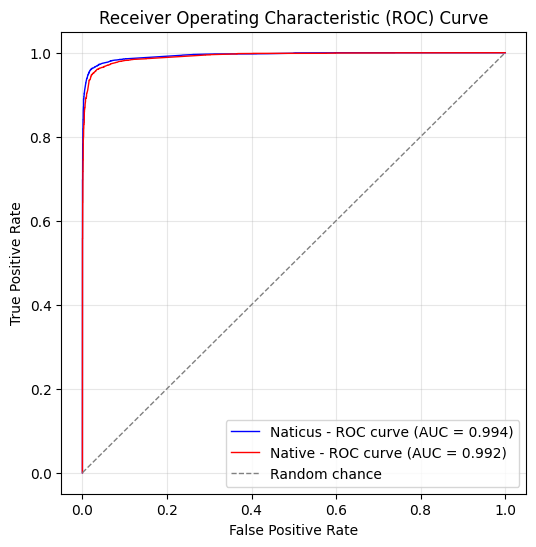

In [37]:
# ROC_AUC curves
fpr_naticus_xgb, tpr_naticus_xgb, _ = roc_curve(y_naticus_test, y_naticus_proba_xgb)
roc_auc_naticus_xgb = auc(fpr_naticus_xgb, tpr_naticus_xgb)
fpr_native_xgb, tpr_native_xgb, _ = roc_curve(y_native_test, y_native_proba_xgb)
roc_auc_native_xgb = auc(fpr_native_xgb, tpr_native_xgb)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_naticus_xgb, tpr_naticus_xgb, color='blue', lw=1, label=f'Naticus - ROC curve (AUC = {roc_auc_naticus_xgb:.3f})')
axes.plot(fpr_native_xgb, tpr_native_xgb, color='red', lw=1, label=f'Native - ROC curve (AUC = {roc_auc_native_xgb:.3f})')
axes.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')

axes.set_title("Receiver Operating Characteristic (ROC) Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid(alpha=0.3)
axes.legend();


Both XGBoost models show excellent performance on the validation set, also demonstrating good generalization..

Training time was significantly longer (~4 min 38 s) compared to other models (Logistic Regression ~8 s).

### Ensemble Learners - AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Hyperparameters grid
param_grid = {
    'n_estimators':[50, 100, 200, 500],
    'learning_rate':[0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)] # Weak classifiers
}

# KFold & search for best hyperparameters
grid_ada_naticus = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42, algorithm="SAMME"),          # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Same metrics as before
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

grid_ada_native = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42, algorithm="SAMME"),          # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Same metrics as before
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

# Training while searching for best hyperparameters
grid_ada_naticus.fit(X_naticus_train, y_naticus_train)
grid_ada_native.fit(X_native_train, y_native_train);

In [95]:
# Saving the results
ada_naticus_results = pd.DataFrame(grid_ada_naticus.cv_results_)
ada_native_results = pd.DataFrame(grid_ada_native.cv_results_)

# Best models 
ada_naticus = grid_ada_naticus.best_estimator_
ada_naticus_ind = grid_ada_naticus.best_index_
ada_native = grid_ada_native.best_estimator_
ada_native_ind = grid_ada_native.best_index_

# Showing best hyperparameters/score
print(40 * "* ")
print("Best Model NATICUS (according to ROC AUC)")
print(f"* Hyperparameters : {grid_ada_naticus.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {ada_naticus_results.loc[ada_naticus_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {ada_naticus_results.loc[ada_naticus_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {ada_naticus_results.loc[ada_naticus_ind, 'mean_test_Accuracy']:.4f}")

print("\n" + 40 * "* " + "\n")

print("Best Model NATIVE (according to ROC AUC)")
print(f"* Hyperparameters : {grid_ada_native.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {ada_native_results.loc[ada_native_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {ada_native_results.loc[ada_native_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {ada_native_results.loc[ada_native_ind, 'mean_test_Accuracy']:.4f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS (according to ROC AUC)
* Hyperparameters : {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 500}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9904
* F1 Score : 0.9592
* Accuracy : 0.9588

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE (according to ROC AUC)
* Hyperparameters : {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 500}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9887
* F1 Score : 0.9550
* Accuracy : 0.9547
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [41]:
# Validation of the best models - Prediction of the class and associated probability
y_naticus_pred_ada = ada_naticus.predict(X_naticus_test)
y_naticus_proba_ada = ada_naticus.predict_proba(X_naticus_test)[:, 1] # Looking at the proba of 1 = proba malware

y_native_pred_ada = ada_native.predict(X_native_test)
y_native_proba_ada = ada_native.predict_proba(X_native_test)[:, 1]

# Printing scores
print(40 * "* ")
print("Best Model NATICUS on validation set")
print(f"* ROC AUC : {roc_auc_score(y_naticus_test, y_naticus_proba_ada):.5f}")
print(f"* F1 Score : {f1_score(y_naticus_test, y_naticus_pred_ada):.5f}")
print(f"* Accuracy : {accuracy_score(y_naticus_test, y_naticus_pred_ada):.5f}")
print("\n" + 40 * "* " + "\n")
print("Best Model NATIVE on validation set")
print(f"* ROC AUC : {roc_auc_score(y_native_test, y_native_proba_ada):.5f}")
print(f"* F1 Score : {f1_score(y_native_test, y_native_pred_ada):.5f}")
print(f"* Accuracy : {accuracy_score(y_native_test, y_native_pred_ada):.5f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS on validation set
* ROC AUC : 0.99078
* F1 Score : 0.96016
* Accuracy : 0.96023

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE on validation set
* ROC AUC : 0.98918
* F1 Score : 0.95495
* Accuracy : 0.95500
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


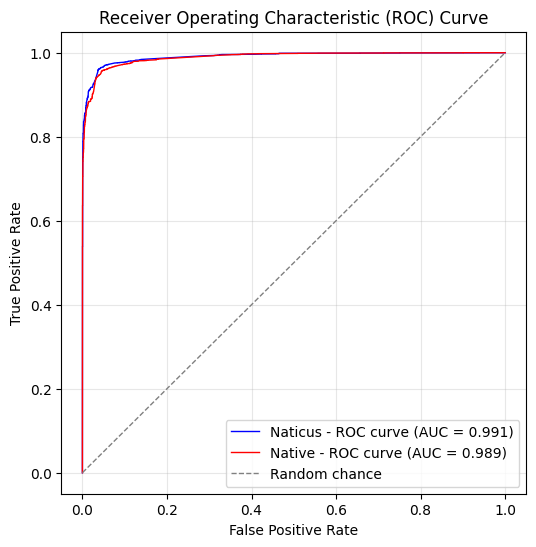

In [42]:
# ROC_AUC curves
fpr_naticus_ada, tpr_naticus_ada, _ = roc_curve(y_naticus_test, y_naticus_proba_ada)
roc_auc_naticus_ada = auc(fpr_naticus_ada, tpr_naticus_ada)
fpr_native_ada, tpr_native_ada, _ = roc_curve(y_native_test, y_native_proba_ada)
roc_auc_native_ada = auc(fpr_native_ada, tpr_native_ada)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_naticus_ada, tpr_naticus_ada, color='blue', lw=1, label=f'Naticus - ROC curve (AUC = {roc_auc_naticus_ada:.3f})')
axes.plot(fpr_native_ada, tpr_native_ada, color='red', lw=1, label=f'Native - ROC curve (AUC = {roc_auc_native_ada:.3f})')
axes.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')

axes.set_title("Receiver Operating Characteristic (ROC) Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid(alpha=0.3)
axes.legend();


### Ensemble Learners - Bagging

In [43]:
from sklearn.ensemble import BaggingClassifier

# Hyperparameters grid
param_grid = {
    'n_estimators':[10, 50, 100, 200, 500],
    'max_samples':[0.5, 0.7, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=5)] # Weak classifiers
}

# KFold & search for best hyperparameters
grid_bag_naticus = GridSearchCV(
    estimator=BaggingClassifier(random_state=42),           # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Same metrics as before
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

grid_bag_native = GridSearchCV(
    estimator=BaggingClassifier(random_state=42),           # Base model 
    param_grid=param_grid,                                  # Search hyperparameters space
    scoring=scoring_metrics,                                # Same metrics as before
    refit='ROC_AUC',                                        # Best model is chosen using 'ROC_AUC'
    cv=10,                                                  # Using 10 split KFold 
    n_jobs=-1                                               # Parallelization : Using all cores
)

# Training while searching for best hyperparameters
grid_bag_naticus.fit(X_naticus_train, y_naticus_train)
grid_bag_native.fit(X_native_train, y_native_train);

In [94]:
# Saving the results
bag_naticus_results = pd.DataFrame(grid_bag_naticus.cv_results_)
bag_native_results = pd.DataFrame(grid_bag_native.cv_results_)

# Best models 
bag_naticus = grid_bag_naticus.best_estimator_
bag_naticus_ind = grid_bag_naticus.best_index_
bag_native = grid_bag_native.best_estimator_
bag_native_ind = grid_bag_native.best_index_

# Showing best hyperparameters/score
print(40 * "* ")
print("Best Model NATICUS (according to ROC AUC)")
print(f"* Hyperparameters : {grid_bag_naticus.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {bag_naticus_results.loc[bag_naticus_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {bag_naticus_results.loc[bag_naticus_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {bag_naticus_results.loc[bag_naticus_ind, 'mean_test_Accuracy']:.4f}")

print("\n" + 40 * "* " + "\n")

print("Best Model NATIVE (according to ROC AUC)")
print(f"* Hyperparameters : {grid_bag_native.best_params_}\n")
print("Scores on crossing validation (mean of the 10 folds):")
print(f"* ROC AUC : {bag_native_results.loc[bag_native_ind, 'mean_test_ROC_AUC']:.4f}")
print(f"* F1 Score : {bag_native_results.loc[bag_native_ind, 'mean_test_F1_Score']:.4f}")
print(f"* Accuracy : {bag_native_results.loc[bag_native_ind, 'mean_test_Accuracy']:.4f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS (according to ROC AUC)
* Hyperparameters : {'estimator': DecisionTreeClassifier(max_depth=5), 'max_samples': 0.5, 'n_estimators': 500}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9843
* F1 Score : 0.9413
* Accuracy : 0.9392

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE (according to ROC AUC)
* Hyperparameters : {'estimator': DecisionTreeClassifier(max_depth=5), 'max_samples': 0.5, 'n_estimators': 500}

Scores on crossing validation (mean of the 10 folds):
* ROC AUC : 0.9739
* F1 Score : 0.9223
* Accuracy : 0.9184
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [45]:
# Validation of the best models - Prediction of the class and associated probability
y_naticus_pred_bag = bag_naticus.predict(X_naticus_test)
y_naticus_proba_bag = bag_naticus.predict_proba(X_naticus_test)[:, 1] # Looking at the proba of 1 = proba malware

y_native_pred_bag = bag_native.predict(X_native_test)
y_native_proba_bag = bag_native.predict_proba(X_native_test)[:, 1]

# Printing scores
print(40 * "* ")
print("Best Model NATICUS on validation set")
print(f"* ROC AUC : {roc_auc_score(y_naticus_test, y_naticus_proba_bag):.5f}")
print(f"* F1 Score : {f1_score(y_naticus_test, y_naticus_pred_bag):.5f}")
print(f"* Accuracy : {accuracy_score(y_naticus_test, y_naticus_pred_bag):.5f}")
print("\n" + 40 * "* " + "\n")
print("Best Model NATIVE on validation set")
print(f"* ROC AUC : {roc_auc_score(y_native_test, y_native_proba_bag):.5f}")
print(f"* F1 Score : {f1_score(y_native_test, y_native_pred_bag):.5f}")
print(f"* Accuracy : {accuracy_score(y_native_test, y_native_pred_bag):.5f}")
print(40 * "* ")

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Best Model NATICUS on validation set
* ROC AUC : 0.98602
* F1 Score : 0.94464
* Accuracy : 0.94318

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Best Model NATIVE on validation set
* ROC AUC : 0.97330
* F1 Score : 0.92034
* Accuracy : 0.91716
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


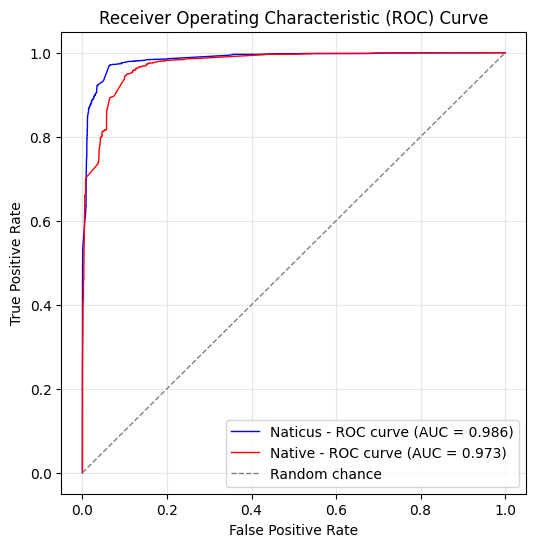

In [46]:
# ROC_AUC curves
fpr_naticus_bag, tpr_naticus_bag, _ = roc_curve(y_naticus_test, y_naticus_proba_bag)
roc_auc_naticus_bag = auc(fpr_naticus_bag, tpr_naticus_bag)
fpr_native_bag, tpr_native_bag, _ = roc_curve(y_native_test, y_native_proba_bag)
roc_auc_native_bag = auc(fpr_native_bag, tpr_native_bag)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_naticus_bag, tpr_naticus_bag, color='blue', lw=1, label=f'Naticus - ROC curve (AUC = {roc_auc_naticus_bag:.3f})')
axes.plot(fpr_native_bag, tpr_native_bag, color='red', lw=1, label=f'Native - ROC curve (AUC = {roc_auc_native_bag:.3f})')
axes.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')

axes.set_title("Receiver Operating Characteristic (ROC) Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid(alpha=0.3)
axes.legend();


## Summary of all methods

Let's put together all the results : accuracy (best KFold & on the validation set), f1_score, roc_auc, and all the roc curves together, to find out the best model.

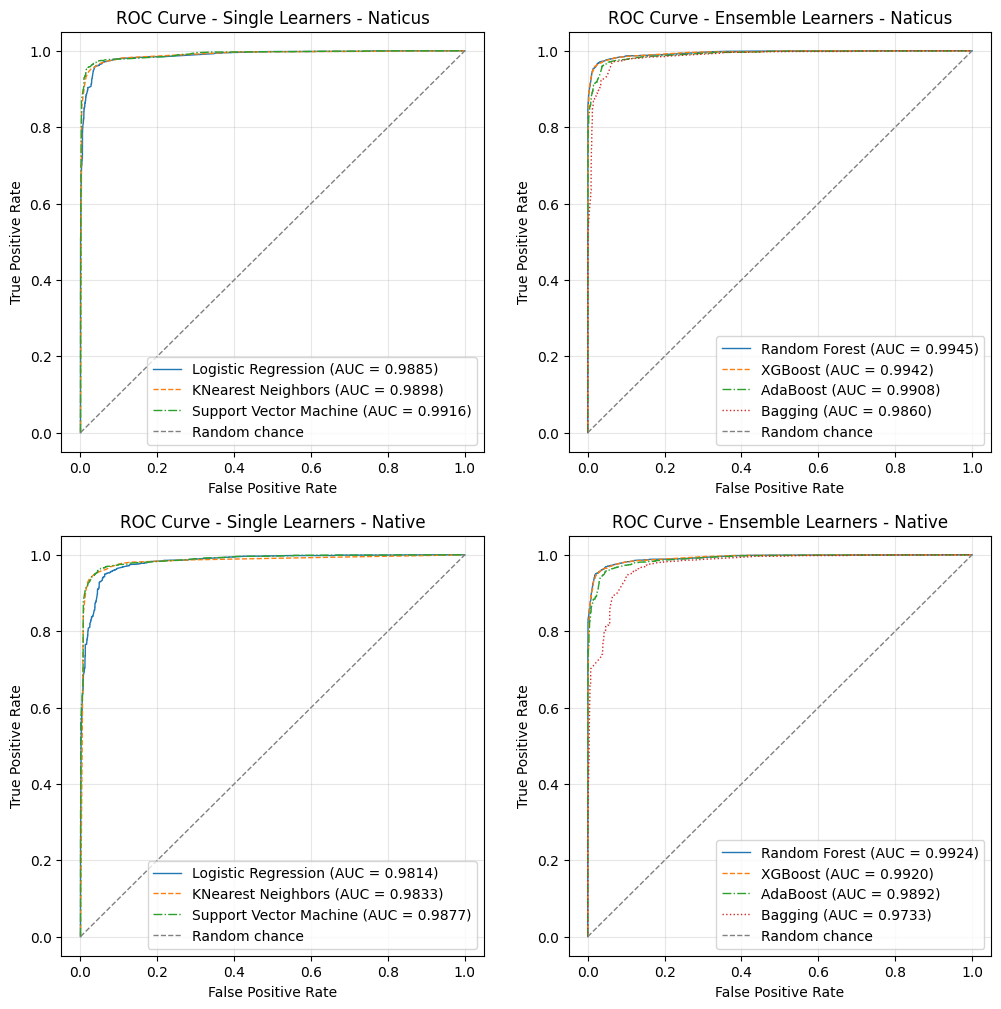

In [105]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()

# First plot - Single Learners on Naticus
axes[0].plot(fpr_naticus_lr, tpr_naticus_lr, color='#1f77b4', lw=1, linestyle='-', label=f'Logistic Regression (AUC = {roc_auc_naticus_lr:.4f})')
axes[0].plot(fpr_naticus_knn, tpr_naticus_knn, color='#ff7f0e', lw=1, linestyle='--', label=f'KNearest Neighbors (AUC = {roc_auc_naticus_knn:.4f})')
axes[0].plot(fpr_naticus_svm, tpr_naticus_svm, color='#2ca02c', lw=1, linestyle='-.', label=f'Support Vector Machine (AUC = {roc_auc_naticus_svm:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')
axes[0].set_title("ROC Curve - Single Learners - Naticus")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].grid(alpha=0.3)
axes[0].legend()

# Second plot - Ensemble Learners on Naticus
axes[1].plot(fpr_naticus_rf, tpr_naticus_rf, color='#1f77b4', lw=1, linestyle='-', label=f'Random Forest (AUC = {roc_auc_naticus_rf:.4f})')
axes[1].plot(fpr_naticus_xgb, tpr_naticus_xgb, color='#ff7f0e', lw=1, linestyle='--', label=f'XGBoost (AUC = {roc_auc_naticus_xgb:.4f})')
axes[1].plot(fpr_naticus_ada, tpr_naticus_ada, color='#2ca02c', lw=1, linestyle='-.', label=f'AdaBoost (AUC = {roc_auc_naticus_ada:.4f})')
axes[1].plot(fpr_naticus_bag, tpr_naticus_bag, color='#d62728', lw=1, linestyle=':', label=f'Bagging (AUC = {roc_auc_naticus_bag:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')
axes[1].set_title("ROC Curve - Ensemble Learners - Naticus")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid(alpha=0.3)
axes[1].legend()

# Third plot - Single Learners on Native
axes[2].plot(fpr_native_lr, tpr_native_lr, color='#1f77b4', lw=1, linestyle='-', label=f'Logistic Regression (AUC = {roc_auc_native_lr:.4f})')
axes[2].plot(fpr_native_knn, tpr_native_knn, color='#ff7f0e', lw=1, linestyle='--', label=f'KNearest Neighbors (AUC = {roc_auc_native_knn:.4f})')
axes[2].plot(fpr_native_svm, tpr_native_svm, color='#2ca02c', lw=1, linestyle='-.', label=f'Support Vector Machine (AUC = {roc_auc_native_svm:.4f})')
axes[2].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')
axes[2].set_title("ROC Curve - Single Learners - Native")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].grid(alpha=0.3)
axes[2].legend()

# Fourth plot - Ensemble Learners on Native
axes[3].plot(fpr_native_rf, tpr_native_rf, color='#1f77b4', lw=1, linestyle='-', label=f'Random Forest (AUC = {roc_auc_native_rf:.4f})')
axes[3].plot(fpr_native_xgb, tpr_native_xgb, color='#ff7f0e', lw=1, linestyle='--', label=f'XGBoost (AUC = {roc_auc_native_xgb:.4f})')
axes[3].plot(fpr_native_ada, tpr_native_ada, color='#2ca02c', lw=1, linestyle='-.', label=f'AdaBoost (AUC = {roc_auc_native_ada:.4f})')
axes[3].plot(fpr_native_bag, tpr_native_bag, color='#d62728', lw=1, linestyle=':', label=f'Bagging (AUC = {roc_auc_native_bag:.4f})')
axes[3].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random chance')
axes[3].set_title("ROC Curve - Ensemble Learners - Native")
axes[3].set_xlabel("False Positive Rate")
axes[3].set_ylabel("True Positive Rate")
axes[3].grid(alpha=0.3)
axes[3].legend();

In [104]:
data = {
    "Classifier": ["KNN", "SVM", "LR", "RF", "XG", "AB", "BG"],
    "KFold Validation Naticus (%)": [95.84, 96.62, 95.27, 96.75, 96.67, 95.88, 93.92],
    "KFold Validation Native (%)": [95.12, 95.71, 94.33, 96.14, 96.15, 95.47, 91.84],
    "Validation Naticus (%)": [95.98, 96.83, 95.78, 97.01, 96.99, 96.02, 94.32],
    "Validation Native (%)": [95.22, 95.67, 94.08, 96.22, 96.26, 95.50, 91.72],
    "ROC_AUC Naticus": [0.9898, 0.9916, 0.9885, 0.9945, 0.9942, 0.9908, 0.9860],
    "ROC_AUC Native": [0.9833, 0.9877, 0.9814, 0.9924, 0.9920, 0.9892, 0.9733],
    "F1 Naticus": [0.9596, 0.9678, 0.9575, 0.9699, 0.9695, 0.9602, 0.9446],
    "F1 Native": [0.9522, 0.9565, 0.9412, 0.9619, 0.9622, 0.9550, 0.9203],
    "Training time (s)": [188.4, 258.3, 8.2, 494.8, 242.5, 252.0, 199.8],
    "Detection time (s)": [21.0, 5.6, 0.0, 1.8, 0.0, 0.9, 1.6]
}

df = pd.DataFrame(data)

# Applying heatmap to see the performances
heatmap = (
    df.style
    .background_gradient(cmap="Greens", subset=[
        "KFold Validation Naticus (%)", "KFold Validation Native (%)",
        "Validation Naticus (%)", "Validation Native (%)",
        "ROC_AUC Naticus", "ROC_AUC Native",
        "F1 Naticus", "F1 Native"
    ])  
    .background_gradient(cmap="Greens_r", subset=[
        "Training time (s)", "Detection time (s)"
    ])  
    .format({
        "KFold Validation Naticus (%)": "{:.2f}", 
        "KFold Validation Native (%)": "{:.2f}",
        "Validation Naticus (%)": "{:.2f}",
        "Validation Native (%)": "{:.2f}",
        "ROC_AUC Naticus": "{:.4f}",
        "ROC_AUC Native": "{:.4f}",
        "F1 Naticus": "{:.4f}",
        "F1 Native": "{:.4f}",
        "Training time (s)": "{:.1f}",
        "Detection time (s)": "{:.1f}"
    })
)
heatmap

,Classifier,KFold Validation Naticus (%),KFold Validation Native (%),Validation Naticus (%),Validation Native (%),ROC_AUC Naticus,ROC_AUC Native,F1 Naticus,F1 Native,Training time (s),Detection time (s)
0,KNN,95.84,95.12,95.98,95.22,0.9898,0.9833,0.9596,0.9522,188.4,21.0
1,SVM,96.62,95.71,96.83,95.67,0.9916,0.9877,0.9678,0.9565,258.3,5.6
2,LR,95.27,94.33,95.78,94.08,0.9885,0.9814,0.9575,0.9412,8.2,0.0
3,RF,96.75,96.14,97.01,96.22,0.9945,0.9924,0.9699,0.9619,494.8,1.8
4,XG,96.67,96.15,96.99,96.26,0.9942,0.9920,0.9695,0.9622,242.5,0.0
5,AB,95.88,95.47,96.02,95.50,0.9908,0.9892,0.9602,0.9550,252.0,0.9
6,BG,93.92,91.84,94.32,91.72,0.9860,0.9733,0.9446,0.9203,199.8,1.6


######################################################################

## Unsupervised learning - Searching for important features - PCA 

Index(['android.permission.READ_PHONE_STATE', 'Result',
       'android.permission.ACCESS_COARSE_LOCATION',
       'android.permission.ACCESS_FINE_LOCATION',
       'android.permission.RECEIVE_BOOT_COMPLETED'],
      dtype='object')
Index(['android.permission.READ_PHONE_STATE',
       'android.permission.ACCESS_COARSE_LOCATION',
       'android.permission.ACCESS_FINE_LOCATION', 'Result',
       'android.permission.RECEIVE_BOOT_COMPLETED'],
      dtype='object')


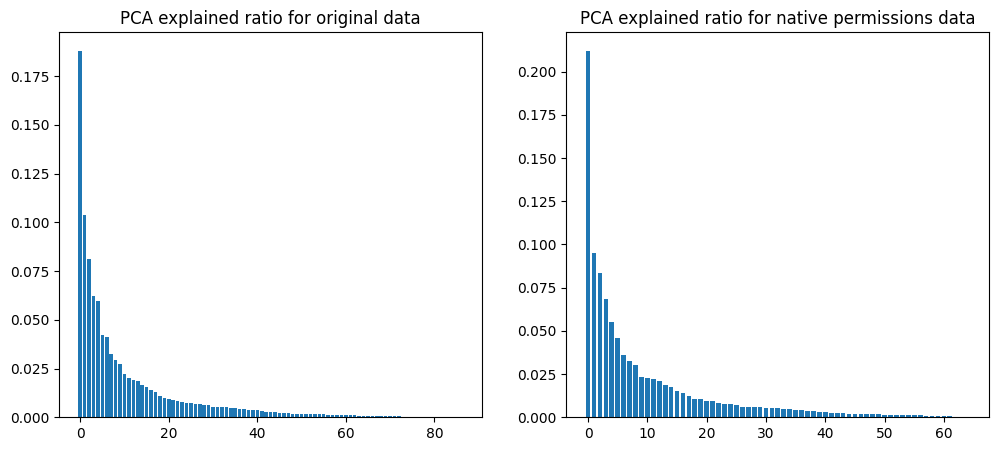

In [61]:
from sklearn.decomposition import PCA

# Computing PCA
pca_original = PCA()
pca_original.fit(original_df)

pca_native = PCA()
pca_native.fit(native_permissions_df)

# Showing the 5 most important permissions for the first PCA vector
first_component_normalized = np.abs(pca_original.components_[0])
max_importance_features = np.arange(original_df.shape[1])[np.argsort(first_component_normalized)[::-1][:5]]
print(original_df.columns[max_importance_features])

first_component_normalized_native = np.abs(pca_native.components_[0])
max_importance_features = np.arange(native_permissions_df.shape[1])[np.argsort(first_component_normalized_native)[::-1][:5]]
print(native_permissions_df.columns[max_importance_features])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes.flatten()

axes[0].bar(range(original_df.shape[1]), pca_original.explained_variance_ratio_)
axes[0].set_title("PCA explained ratio for original data")

axes[1].bar(range(native_permissions_df.shape[1]), pca_native.explained_variance_ratio_)
axes[1].set_title("PCA explained ratio for native permissions data");

In each cases (only native permissions on one side, and all permissions on the other side), we don't observe really important features, only one with about 20% of explained variance ratio and some other with about 10%. This doesn't shows a clear trend, however using the composition of the first vectors of the PCA, we can have a look at the permissions requests with most impact. => non c'est faux mdr

## Unsupervised learning - Trying to cluster the benign/malware - KMeans 

True positive : 11742/14700 = 79.88%
True negative : 11554/14632 = 78.96%
False negative (type 2) : 2958/14700 = 20.12%
False positive (type 1) : 3078/14632 = 21.04%


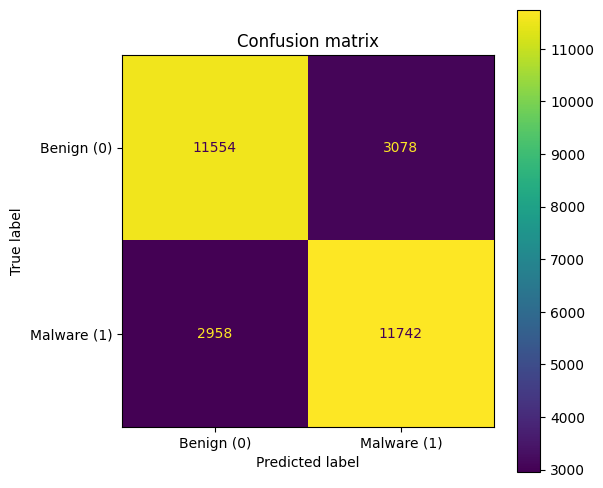

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dropping the last columns with the classification benign/malware
original_df_no_result = original_df.drop("Result", axis=1)

# Clustering in the original space
kmeans_original = KMeans(n_clusters=2)
kmeans_original.fit(original_df_no_result)
y_pred_original = kmeans_original.predict(original_df_no_result)

# Looking at the predictions results - changing 0 to 1 in the prediction, to match the original one (a majority of 0 should match the 0 original label)
expected_result_original = original_df["Result"].to_numpy()
comparison = y_pred_original == expected_result_original
# If less than half of the data are correctly assigned, change 0 to 1 in the prediction
if comparison.sum() <= len(expected_result_original)//2:
    y_pred_original = np.where(y_pred_original == 0, 1, 0) 

# Confusion matrix
cm = confusion_matrix(expected_result_original, y_pred_original, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign (0)', 'Malware (1)'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
ax.set_title("Confusion matrix");

# Proportions 
print(f"True positive : {cm[1,1]}/{cm[1,0] + cm[1,1]} = {100 * cm[1,1]/(cm[1,0] + cm[1,1]):.2f}%")
print(f"True negative : {cm[0,0]}/{cm[0,0] + cm[0,1]} = {100 * cm[0,0]/(cm[0,0] + cm[0,1]):.2f}%")
print(f"False negative (type 2) : {cm[1,0]}/{cm[1,0] + cm[1,1]} = {100 * cm[1,0]/(cm[1,0] + cm[1,1]):.2f}%")
print(f"False positive (type 1) : {cm[0,1]}/{cm[0,0] + cm[0,1]} = {100 * cm[0,1]/(cm[0,0] + cm[0,1]):.2f}%")

We take a look at the impact of the topography of the initial space, does it enable an easy clustering and if so, we could then imagine to possibly go further with SVM for example in order to accept new data.

## Supervised learning 

In [ ]:
from sklearn.utils import shuffle

# Splitting data from label
X = original_df.drop("Result", axis=1).to_numpy()
y = original_df["Result"].to_numpy()

# Splitting in 70/30 training & testing - we wish to have approximately 50% of malware and benign apps in the training and testing set for better performances
threshold = int(original_df.shape[0] * 0.7)
inds = np.array(shuffle(range(X.shape[0]), random_state=42))

X_train = X[inds[:threshold]]
y_train = y[inds[:threshold]]
X_test = X[inds[threshold:]]
y_test = y[inds[threshold:]]

# Checking we've about half malware/benign in training and testing dataset
print(f"Training dataset : malware = {y_train.sum()} / benign = {len(y_train) - y_train.sum()} -> {100 * y_train.sum() / len(y_train):.2f}% & {100 - 100 * y_train.sum() / len(y_train):.2f}%")
print(f"Testing dataset : malware = {y_test.sum()} / benign = {len(y_test) - y_test.sum()} -> {100 * y_test.sum() / len(y_test):.2f}% & {100 - 100 * y_test.sum() / len(y_test):.2f}%")

Training dataset : malware = 10266 / benign = 10266 -> 50.00% & 50.00%
Testing dataset : malware = 4434 / benign = 4366 -> 50.39% & 49.61%


## SVM

True positive : 4253/4434 = 95.92%
True negative : 4152/4366 = 95.10%
False negative (type 2) : 181/4434 = 4.08%
False positive (type 1) : 214/4366 = 4.90%


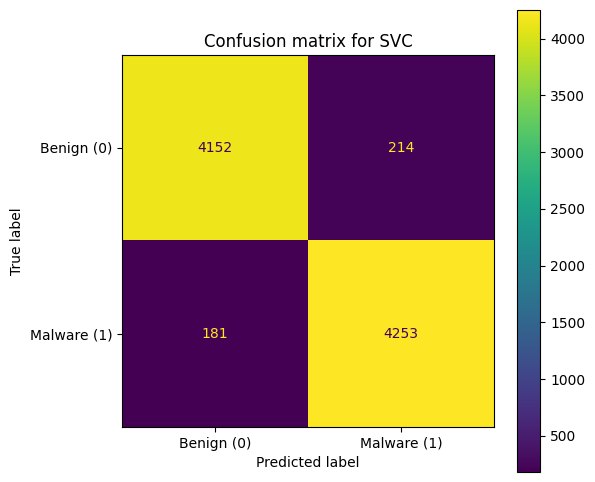

In [ ]:
from sklearn.svm import SVC

# Computing svc
svc_original = SVC(kernel="linear", C=1.) # We keep a low C value in order to have better generalization and no kernel for now
svc_original.fit(X_train, y_train)
y_pred = svc_original.predict(X_test)

# Confusion matrix
cm_svc = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Benign (0)', 'Malware (1)'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
ax.set_title("Confusion matrix for SVC");

# Proportions 
print(f"True positive : {cm_svc[1,1]}/{cm_svc[1,0] + cm_svc[1,1]} = {100 * cm_svc[1,1]/(cm_svc[1,0] + cm_svc[1,1]):.2f}%")
print(f"True negative : {cm_svc[0,0]}/{cm_svc[0,0] + cm_svc[0,1]} = {100 * cm_svc[0,0]/(cm_svc[0,0] + cm_svc[0,1]):.2f}%")
print(f"False negative (type 2) : {cm_svc[1,0]}/{cm_svc[1,0] + cm_svc[1,1]} = {100 * cm_svc[1,0]/(cm_svc[1,0] + cm_svc[1,1]):.2f}%")
print(f"False positive (type 1) : {cm_svc[0,1]}/{cm_svc[0,0] + cm_svc[0,1]} = {100 * cm_svc[0,1]/(cm_svc[0,0] + cm_svc[0,1]):.2f}%")


In [ ]:
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.metrics import recall_score, accuracy_score

# Fine tunning of the C parameter
param_grid = {'C': np.logspace(-3, 2, 5), 
              "gamma": np.logspace(-4, 1, 5)}

# We keep the accuracy -> (TP+TN)/(TP+TN+FN+FP) and the recall -> TP/(TP+FN)
scoring_metrics = ['accuracy', 'recall']

# Kfold in order to have better results with SVC (10 splits according to the recommendations)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Base model initialization
base_svc = SVC(kernel="rbf", random_state=42)

# Using GridSearchCV
grid_search = GridSearchCV(
    estimator=base_svc,                                      # Base model 
    param_grid=param_grid,                                   # Search hyperparameters space
    scoring=scoring_metrics,                                 # Used metrics
    refit='recall',                                          # Best model is chosen using 'recall'
    cv=KFold(n_splits=10, shuffle=True, random_state=42),    # Using 10 split KFold 
    verbose=2,                                               # Showing progression
    n_jobs=-1                                                # Parallelization : Using all cores
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END ..............................C=0.001, gamma=0.0001; total time=  52.1s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  52.1s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  52.4s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  52.7s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  52.9s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  53.0s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  53.0s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  53.8s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  52.3s
[CV] END ..............................C=0.001, gamma=0.0001; total time=  53.4s
[CV] END ...............C=0.001, gamma=0.0017782794100389228; total time=  53.0s
[CV] END ...............C=0.001, gamma=0.00177

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02]),
                         'gamma': array([1.00000000e-04, 1.77827941e-03, 3.16227766e-02, 5.62341325e-01,
       1.00000000e+01])},
             refit='recall', scoring=['accuracy', 'recall'], verbose=2)

In [ ]:
# Getting all results from the GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Looking for the best model parameters
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
best_recall_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_ # Has been retrained on the all data by default

print(f"Best C value : {best_C}")
print(f"Best gamma value : {best_gamma}")
print(f"Best Recall associated: {best_recall_score:.4f}")
print(f"Best Accuracy associated: {best_recall_score:.4f}")

# Global results
print("\nMeans of the KFold for each C/gamma pairs :")
print(results[['param_C', 'param_gamma', 'mean_test_accuracy', 'mean_test_recall']])

Best C value : 0.001
Best gamma value : 10.0
Best Recall associated: 0.9907

Means of the KFold for each C/gamma pairs :
     param_C param_gamma  mean_test_accuracy  mean_test_recall
0      0.001      0.0001            0.492500          0.300000
1      0.001    0.001778            0.492500          0.300000
2      0.001    0.031623            0.876534          0.851840
3      0.001    0.562341            0.718001          0.971621
4      0.001        10.0            0.597653          0.990660
5   0.017783      0.0001            0.492500          0.300000
6   0.017783    0.001778            0.882281          0.867796
7   0.017783    0.031623            0.942237          0.961568
8   0.017783    0.562341            0.944282          0.918058
9   0.017783        10.0            0.782290          0.570597
10  0.316228      0.0001            0.882720          0.868193
11  0.316228    0.001778            0.940629          0.957657
12  0.316228    0.031623            0.954169          0.9644

In [ ]:
# Predicting the labels
y_pred_finetuned = best_estimator.predict(X_test)

# Showing the recall and accuracy
print(f"Recall finetuned model: {recall_score(y_test, y_pred_finetuned):.6f}")
print(f"Accuracy finetuned model: {accuracy_score(y_test, y_pred_finetuned):.4f}")

Recall finetuned model: 0.993234
Accuracy finetuned model: 0.5636


Really good recall score, but the accuracy is really bad. Why do we have those results ? We had an extreme unbalanced value pair, one could say we detect almost all malware, but on the other hand the accuracy is really bad. This is explained by the fact that we optimized only the recall. Lets use the F1 score which is a good compromise between recall and accuracy.

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.metrics import recall_score, accuracy_score, f1_score

# Fine tunning of the C parameter
param_grid = {'C': np.logspace(-2, 2, 5), 
              "gamma": np.logspace(-3, 1, 5)}

# We keep the accuracy -> (TP+TN)/(TP+TN+FN+FP) and the recall -> TP/(TP+FN)
scoring_metrics = ['accuracy', 'recall', 'f1']

# Kfold in order to have better results with SVC (10 splits according to the recommendations)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Base model initialization
base_svc = SVC(kernel="rbf", random_state=42)

# Using GridSearchCV
grid_search_f1 = GridSearchCV(
    estimator=base_svc,                                      # Base model 
    param_grid=param_grid,                                   # Search hyperparameters space
    scoring=scoring_metrics,                                 # Used metrics
    refit='f1',                                        # Best model is chosen using 'f1_score'
    cv=KFold(n_splits=10, shuffle=True, random_state=42),    # Using 10 split KFold 
    verbose=2,                                               # Showing progression
    n_jobs=-1                                                # Parallelization : Using all cores
)

grid_search_f1.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END ................................C=0.01, gamma=0.001; total time=  52.6s
[CV] END ................................C=0.01, gamma=0.001; total time=  52.9s
[CV] END ................................C=0.01, gamma=0.001; total time=  53.0s
[CV] END ................................C=0.01, gamma=0.001; total time=  53.1s
[CV] END ................................C=0.01, gamma=0.001; total time=  53.4s
[CV] END ................................C=0.01, gamma=0.001; total time=  53.6s
[CV] END ................................C=0.01, gamma=0.001; total time=  53.6s
[CV] END ................................C=0.01, gamma=0.001; total time=  53.6s
[CV] END .................................C=0.01, gamma=0.01; total time=  33.7s
[CV] END .................................C=0.01, gamma=0.01; total time=  33.7s
[CV] END .................................C=0.01, gamma=0.01; total time=  33.6s
[CV] END .................................C=0.

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             refit='f1', scoring=['accuracy', 'recall', 'f1'], verbose=2)

In [ ]:
# Getting all results from the GridSearchCV
results_f1 = pd.DataFrame(grid_search_f1.cv_results_)

# Looking for the best model parameters
best_C_f1 = grid_search_f1.best_params_['C']
best_gamma_f1 = grid_search_f1.best_params_['gamma']
best_recall_score_f1 = grid_search_f1.best_score_
best_estimator_f1 = grid_search_f1.best_estimator_ # Has been retrained on the all data by default

print(f"Best C value : {best_C_f1}")
print(f"Best gamma value : {best_gamma_f1}")
print(f"Best Recall associated: {best_recall_score_f1:.4f}")
print(f"Best Accuracy associated: {best_recall_score_f1:.4f}")

# Global results
print("\nMeans of the KFold for each C/gamma pairs :")
print(results_f1[['param_C', 'param_gamma', 'mean_test_accuracy', 'mean_test_recall']])

Best C value : 10.0
Best gamma value : 0.1
Best Recall associated: 0.9674
Best Accuracy associated: 0.9674

Means of the KFold for each C/gamma pairs :
   param_C param_gamma  mean_test_accuracy  mean_test_recall
0     0.01       0.001            0.492549          0.300097
1     0.01        0.01            0.901520          0.888223
2     0.01         0.1            0.944867          0.963107
3     0.01         1.0            0.950078          0.937743
4     0.01        10.0            0.772744          0.551610
5      0.1       0.001            0.901812          0.887935
6      0.1        0.01            0.940240          0.956870
7      0.1         0.1            0.959089          0.966622
8      0.1         1.0            0.919881          0.856081
9      0.1        10.0            0.843610          0.694463
10     1.0       0.001            0.939899          0.956971
11     1.0        0.01            0.953195          0.963867
12     1.0         0.1            0.965323          0.9

In [ ]:
# Predicting the labels
y_pred_finetuned_f1 = best_estimator_f1.predict(X_test)

# Showing the recall and accuracy
print(f"Recall finetuned model: {recall_score(y_test, y_pred_finetuned_f1):.6f}")
print(f"Accuracy finetuned model: {accuracy_score(y_test, y_pred_finetuned_f1):.4f}")

Recall finetuned model: 0.963013
Accuracy finetuned model: 0.9683


In [ ]:
# Refining the C value 10 is a bit high, let's optimized closer to it
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.metrics import recall_score, accuracy_score, f1_score

# Fine tunning of the C parameter
param_grid = {'C': np.linspace(5, 15, 5), 
              "gamma": np.logspace(0.05, 0.15, 5)}

# We keep the accuracy -> (TP+TN)/(TP+TN+FN+FP) and the recall -> TP/(TP+FN)
scoring_metrics = ['accuracy', 'recall', 'f1']

# Kfold in order to have better results with SVC (10 splits according to the recommendations)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Base model initialization
base_svc = SVC(kernel="rbf", random_state=42)

# Using GridSearchCV
grid_search_f1_finetuned = GridSearchCV(
    estimator=base_svc,                                      # Base model 
    param_grid=param_grid,                                   # Search hyperparameters space
    scoring=scoring_metrics,                                 # Used metrics
    refit='f1',                                              # Best model is chosen using 'f1_score'
    cv=KFold(n_splits=10, shuffle=True, random_state=42),    # Using 10 split KFold 
    verbose=2,                                               # Showing progression
    n_jobs=-1                                                # Parallelization : Using all cores
)

grid_search_f1_finetuned.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  39.2s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  39.4s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  39.5s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  39.7s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  39.7s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  39.8s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  39.9s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  40.3s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  40.2s
[CV] END ....................C=5.0, gamma=1.1220184543019633; total time=  40.6s
[CV] END ....................C=5.0, gamma=1.1885022274370185; total time=  41.5s
[CV] END ....................C=5.0, gamma=1.18

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': array([ 5. ,  7.5, 10. , 12.5, 15. ]),
                         'gamma': array([1.12201845, 1.18850223, 1.25892541, 1.33352143, 1.41253754])},
             refit='f1', scoring=['accuracy', 'recall', 'f1'], verbose=2)

Looking at other good parameters pairs

In [ ]:
# Looking at other good hyperparameters of the gridsearch - looking for better generalization on validation set -> the C value of the best result seems a bit low
five_next_best_ind = np.argsort(results["mean_test_recall"], axis=1)[::-1][1:5]
other_swc = [SVC(kernel="rbf", C=C, gamma=gamma) for C,gamma in zip(results["param_C"][five_next_best_ind], results["param_gamma"][five_next_best_ind])]
predictions = []

# Training & Predicting
print("Training ...")
for model in other_swc:
    print("* ", end="")
    model.fit(X_train, y_train)
    predictions.append(model.predict(X_test))
print("Done")

# Showing recall scores
recall_scores = []
for pred in predictions:
    recall_scores.append(recall_score(y_test, pred))

Training ...
* * * * Done


In [ ]:
print(results["param_C"][five_next_best_ind])
print(results["param_gamma"][five_next_best_ind])
print(recall_scores)

3        0.001
12    0.316228
17    5.623413
21       100.0
Name: param_C, dtype: object
3     0.562341
12    0.031623
17    0.031623
21    0.001778
Name: param_gamma, dtype: object
[0.9733874605322508, 0.963915200721696, 0.9654939106901218, 0.9625620207487596]
